## Multi-Agent Highway MDP — New simulations workbook
We will run the built-in `simulate_highway_multiagent_sql`.

In [1]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import sqlite3
import importlib.util, sys
from pathlib import Path
import mdp_module as mdp_mod
import multi_agent_highway_sql as highway_mod

In [2]:
# ----------------------------------------------------------------------
# Parameters
# ----------------------------------------------------------------------
N = 200
T = 100
seed = 1

# Geometry
num_lanes_total = 4
lane_directions = [1, 1, -1, -1]
lane_width = 3.75
interference_max_range = 500.0

# Radio / propagation
noise_mw = 1e-9
pathloss_n_los = 2.0
pathloss_n_nlos = 3.5
desired_link_distance_m = 10.0

# Initial spacing
min_initial_gap = 2.0


#sql database
bler_table_path = str('sinr_bler_lookup_table.csv')

In [3]:
env=highway_mod.HighwayMultiAgentEnvSQL(num_agents=N, T=T, seed=seed, bler_table_path=bler_table_path, num_lanes_total=num_lanes_total, lane_directions=lane_directions, lane_width=lane_width, interference_max_range=  interference_max_range)

In [4]:
print(env.bler_table is not None) # True if CSV loaded correctly
print(env._bler_points is not None) # True if points DataFrame exists

True
True


In [5]:
out=highway_mod.simulate_highway_multiagent_sql(N=N, T=T, seed=seed, bler_table_path=bler_table_path, num_lanes_total=num_lanes_total, lane_directions=lane_directions, lane_width=lane_width, interference_max_range=  interference_max_range)

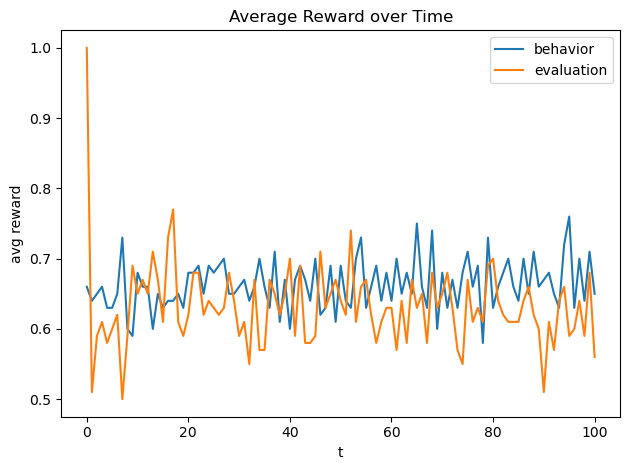

In [6]:
# Extract series
t = np.arange(len(out["avg_rew_b"]))
avg_rew_b = out["avg_rew_b"]
avg_rew_e = out["avg_rew_e"]
succ_b, coll_b, unav_b = out["succ_b"], out["coll_b"], out["unav_b"]
succ_e, coll_e, unav_e = out["succ_e"], out["coll_e"], out["unav_e"]
hist_b, hist_e = out["history_b"], out["history_e"]

# Plot 1: Average Reward over Time
plt.figure()
plt.plot(t, avg_rew_b, label="behavior")
plt.plot(t, avg_rew_e, label="evaluation")
plt.xlabel("t")
plt.ylabel("avg reward")
plt.title("Average Reward over Time")
plt.legend()
plt.tight_layout()


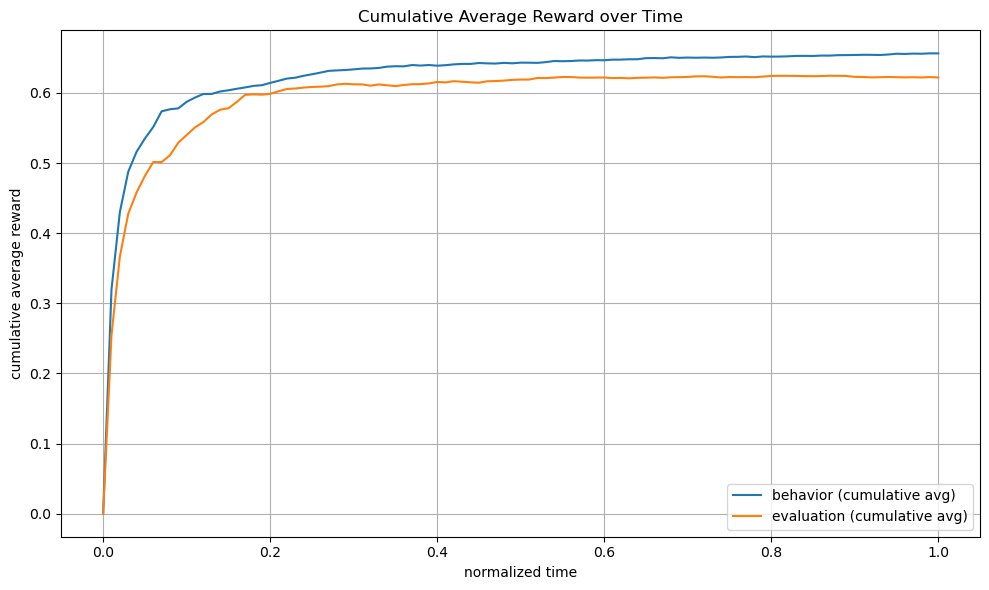

In [7]:
# Calculate cumulative averages
# Make first value of cum_avg_rew_e same as cum_avg_rew_b
avg_rew_e[0] = 0
avg_rew_b[0] = 0
cum_avg_rew_b = np.cumsum(avg_rew_b) / (np.arange(len(avg_rew_b)) + 1)
cum_avg_rew_e = np.cumsum(avg_rew_e) / (np.arange(len(avg_rew_e)) + 1)

# Create normalized time axis from 0 to 1
t_normalized = np.linspace(0, 1, len(t))

# Plot cumulative average rewards
plt.figure(figsize=(10, 6))
plt.plot(t_normalized, cum_avg_rew_b, label="behavior (cumulative avg)", linestyle='-')
plt.plot(t_normalized, cum_avg_rew_e, label="evaluation (cumulative avg)", linestyle='-')
plt.xlabel("normalized time")
plt.ylabel("cumulative average reward")
plt.title("Cumulative Average Reward over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()

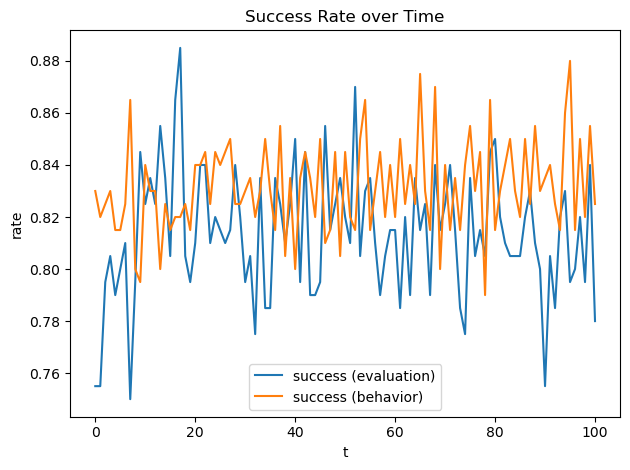

In [8]:

succ_e[0] = succ_e[1] # Fix first value to avoid large spike
# Plot 2: Success Rate
plt.figure()
plt.plot(t, succ_e, label="success (evaluation)")
plt.plot(t, succ_b, label="success (behavior)")
plt.xlabel("t")
plt.ylabel("rate")
plt.title("Success Rate over Time")
plt.legend()
plt.tight_layout()




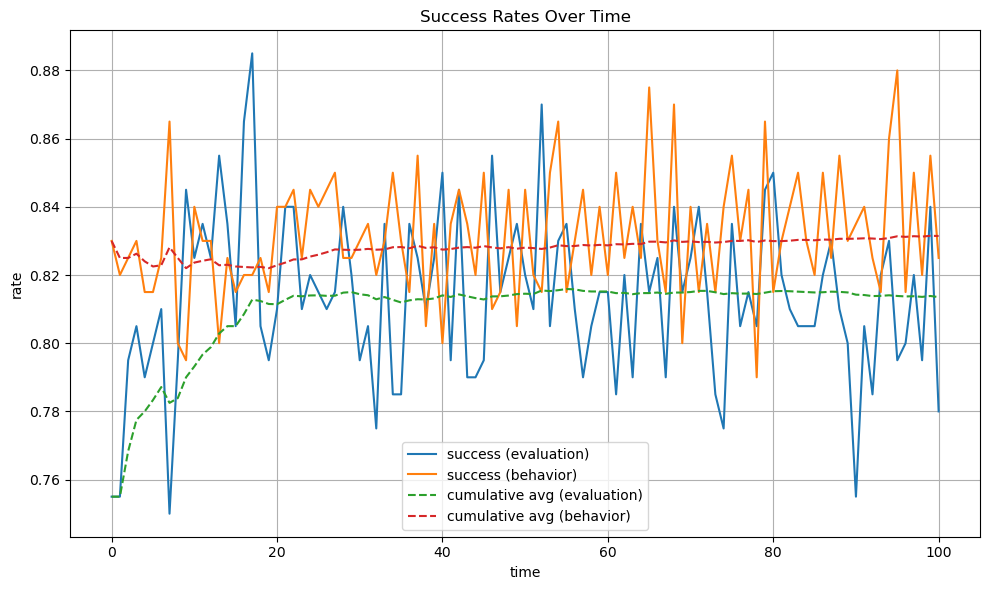

In [9]:

# Calculate cumulative averages for success rates
cum_succ_e = np.cumsum(succ_e) / (np.arange(len(succ_e)) + 1)
cum_succ_b = np.cumsum(succ_b) / (np.arange(len(succ_b)) + 1)

plt.figure(figsize=(10, 6))
plt.plot(t, succ_e, label="success (evaluation)")
plt.plot(t, succ_b, label="success (behavior)")
plt.plot(t, cum_succ_e, label="cumulative avg (evaluation)", linestyle='--')
plt.plot(t, cum_succ_b, label="cumulative avg (behavior)", linestyle='--')
plt.xlabel("time")
plt.ylabel("rate")
plt.title("Success Rates Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [10]:
print("Success rate average evaluation: " + str(succ_e.mean()))
print("Success rate average behavior: " + str(succ_b.mean()))

Success rate average evaluation: 0.8135148514851485
Success rate average behavior: 0.8314356435643564


/var/folders/ly/jqp21h79689gdfzrwpydsm4mgt6yr8/T/ipykernel_17418/3699740889.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lane_width = float(out['layout']['lane_width'])
/var/folders/ly/jqp21h79689gdfzrwpydsm4mgt6yr8/T/ipykernel_17418/3699740889.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num_lanes = int(out['layout']['num_lanes_total'])


'highway_sim.gif'

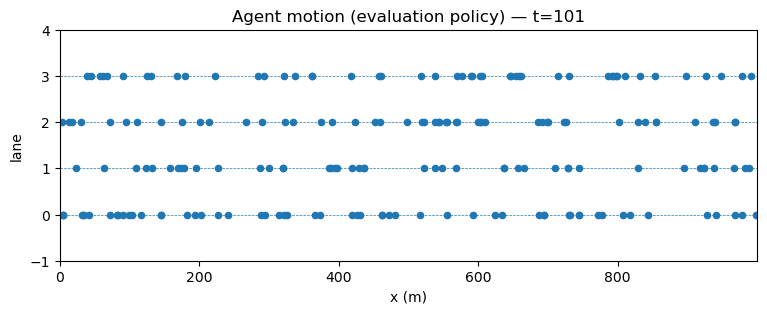

In [11]:
hist = hist_e
X = hist['x']    # (T+1, N)
LANE = hist['lane']  # (T+1, N)
lane_dirs = out['layout']['lane_directions']  # shape (num_lanes,)
lane_width = float(out['layout']['lane_width'])
num_lanes = int(out['layout']['num_lanes_total'])
road_length = float(np.max(X)) if np.max(X) > 0 else 1000.0  # rough axis scale

fig, ax = plt.subplots(figsize=(9, 3))
ax.set_xlim(0, road_length)
ax.set_ylim(-1, num_lanes)
ax.set_xlabel('x (m)')
ax.set_ylabel('lane')
ax.set_title('Agent motion (evaluation policy)')

# Draw lane centerlines
for ell in range(num_lanes):
    ax.axhline(ell, linestyle='--', linewidth=0.5)

scat = ax.scatter(X[0], LANE[0], s=20)

def update(frame):
    scat.set_offsets(np.c_[X[frame], LANE[frame]])
    ax.set_title(f'Agent motion (evaluation policy) — t={frame}')
    return scat,

anim = FuncAnimation(fig, update, frames=X.shape[0], interval=60, blit=True)

# Save GIF
out_path = Path('highway_sim.gif')
anim.save(out_path, writer=PillowWriter(fps=10))
out_path.as_posix()

In [ ]:
# Custom platoon policy:
# - prefers action 1 when idle/successful
# - explores on collisions/unavailable
pi_platoon = np.array([
    [0, 1, 0],  # label 0: idle
    [0, 1, 0],  # label 1: success
    [0, 1, 0],  # label 2: collision
    [0, 1, 0],  # label 3: unavailable
])

# Other vehicles (non-platoon) are more conservative, biased to action 2
pi_others = np.ones((4, 3)) / 3.0

def behavior_policy() -> np.ndarray:
    """π_b(a|s): uniform over actions for every label."""
    return np.ones((4, 3)) / 3.0

def evaluation_policy() -> np.ndarray:
    """π_e(a|s): biased towards action 0 on {idle, success}; exploratory on {collision, unavailable}."""
    p = np.zeros((4, 3))
    p[0] = np.array([0.0, 1.0, 0])  # idle
    p[1] = np.array([1, 0, 0])  # success
    p[2] = np.array([1, 0, 0])  # collision
    p[3] = np.array([0, 1, 0])  # unavailable
    return p
# Run with these explicit policies
result = highway_mod.simulate_highway_multiagent_sql(
    N=N,
    T=T,
    seed=seed,
    bler_table_path=bler_table_path, 
    num_lanes_total=num_lanes_total, 
    lane_directions=lane_directions, 
    lane_width=lane_width, 
    interference_max_range=  
    interference_max_range,
    platoon_indices=[0, 1, 2, 3, 4],
    platoon_policy=pi_platoon,
    others_policy=pi_others,
)

# Quick metrics
print("Average rewards over time:", result["avg_rew_group"])
print("Mean success rate over time:", np.mean(result["succ_group"]))


Average rewards over time: [0.62 0.58 0.59 0.66 0.73 0.64 0.59 0.58 0.66 0.72 0.65 0.65 0.71 0.65
 0.72 0.59 0.65 0.68 0.61 0.63 0.65 0.7  0.61 0.71 0.75 0.71 0.67 0.7
 0.65 0.61 0.69 0.68 0.67 0.73 0.72 0.73 0.69 0.57 0.65 0.67 0.74 0.68
 0.63 0.66 0.69 0.64 0.62 0.61 0.68 0.61 0.63 0.72 0.78 0.62 0.63 0.7
 0.71 0.65 0.59 0.63 0.59 0.65 0.7  0.65 0.69 0.68 0.61 0.62 0.65 0.67
 0.66 0.64 0.63 0.66 0.73 0.67 0.68 0.66 0.7  0.6  0.71 0.64 0.68 0.69
 0.61 0.67 0.69 0.67 0.66 0.68 0.61 0.67 0.69 0.67 0.64 0.71 0.67 0.6
 0.73 0.66 0.65]
Mean success rate over time: 0.8308415841584158


In [13]:

def build_masks(N, platoon_indices):
    platoon = np.zeros(N, dtype=bool)
    platoon[np.asarray(platoon_indices, dtype=int)] = True
    others = ~platoon
    return platoon, others

def stack_time(series_list):
    """series_list: list of length T+1; each item is shape (N,) -> array (T+1, N)"""
    return np.vstack(series_list)


In [14]:
def compare_groups(result, N, platoon_indices):
    # Extract time series
    labels = result["labels_group"]     # list length T+1 of (N,)
    rewards = result["rewards_group"]   # list length T+1 of (N,)
    actions = result["actions_group"]   # list length T+1 of (N,)

    L = stack_time(labels)[1:]          # use t=1..T (post-action), shape (T, N)
    R = stack_time(rewards)             # rewards t=0..T, shape (T+1, N)
    A = stack_time(actions)             # actions t=0..T, shape (T+1, N)

    platoon, others = build_masks(N, platoon_indices)

    # Per-timestep rates
    succ_p_t = (L[:, platoon] == 1).mean(axis=1)
    succ_o_t = (L[:, others]  == 1).mean(axis=1)

    coll_p_t = (L[:, platoon] == 2).mean(axis=1)
    coll_o_t = (L[:, others]  == 2).mean(axis=1)

    unav_p_t = (L[:, platoon] == 3).mean(axis=1)
    unav_o_t = (L[:, others]  == 3).mean(axis=1)

    # Per-timestep average reward
    rew_p_t = R[:, platoon].mean(axis=1)
    rew_o_t = R[:, others].mean(axis=1)

    # Cumulative reward per agent (distribution)
    cum_rew_p = R[:, platoon].sum(axis=0)   # shape (#platoon,)
    cum_rew_o = R[:, others].sum(axis=0)    # shape (#others,)

    # Action usage shares over all time
    def action_share(mask):
        counts = np.bincount(A[:, mask].ravel(), minlength=3).astype(float)
        return counts / counts.sum()
    act_share_p = action_share(platoon)     # array(3,)
    act_share_o = action_share(others)      # array(3,)

    # Simple aggregates
    summary = {
        "success_rate_mean": {
            "platoon": float(succ_p_t.mean()),
            "others":  float(succ_o_t.mean())
        },
        "collision_rate_mean": {
            "platoon": float(coll_p_t.mean()),
            "others":  float(coll_o_t.mean())
        },
        "unavailable_rate_mean": {
            "platoon": float(unav_p_t.mean()),
            "others":  float(unav_o_t.mean())
        },
        "avg_reward_mean": {
            "platoon": float(rew_p_t.mean()),
            "others":  float(rew_o_t.mean())
        },
        "action_share": {
            "platoon": {"a0": float(act_share_p[0]), "a1": float(act_share_p[1]), "a2": float(act_share_p[2])},
            "others":  {"a0": float(act_share_o[0]), "a1": float(act_share_o[1]), "a2": float(act_share_o[2])},
        },
        "cum_reward_distribution": {
            "platoon": cum_rew_p,   # you can compute mean/std/percentiles as needed
            "others":  cum_rew_o,
        },
        # Time series (useful for plotting)
        "timeseries": {
            "success": {"platoon": succ_p_t, "others": succ_o_t},
            "collision": {"platoon": coll_p_t, "others": coll_o_t},
            "unavailable": {"platoon": unav_p_t, "others": unav_o_t},
            "avg_reward": {"platoon": rew_p_t, "others": rew_o_t},
        }
    }
    return summary


In [15]:

summary = compare_groups(result, N=N, platoon_indices=[0, 1, 2, 3, 4])

print("Mean success rate – platoon:", summary["success_rate_mean"]["platoon"])
print("Mean success rate – others :", summary["success_rate_mean"]["others"])
print("Mean avg reward   – platoon:", summary["avg_reward_mean"]["platoon"])
print("Mean avg reward   – others :", summary["avg_reward_mean"]["others"])
print("Action shares – platoon:", summary["action_share"]["platoon"])
print("Action shares – others :", summary["action_share"]["others"])


Mean success rate – platoon: 0.5207920792079207
Mean success rate – others : 0.8387915714648387
Mean avg reward   – platoon: 0.041584158415841586
Mean avg reward   – others : 0.6775831429296774
Action shares – platoon: {'a0': 0.9900990099009901, 'a1': 0.009900990099009901, 'a2': 0.0}
Action shares – others : {'a0': 0.3334348819497334, 'a1': 0.33145468392993144, 'a2': 0.3351104341203351}


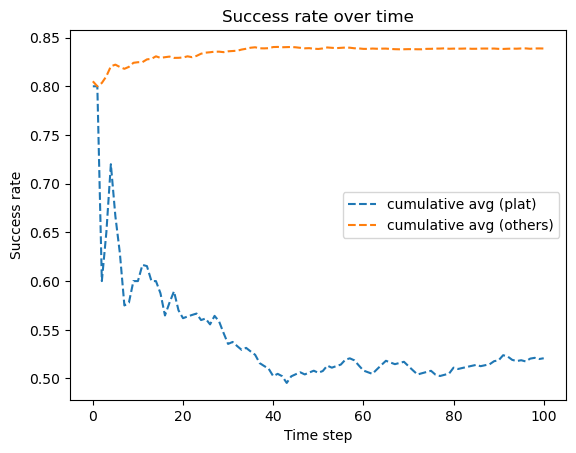

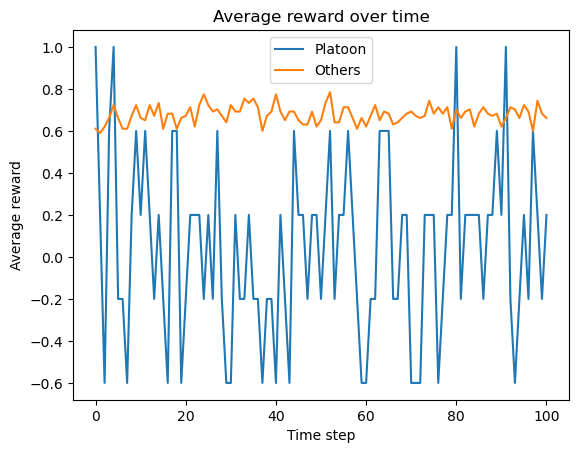

In [16]:

ts = summary["timeseries"]


# Calculate cumulative averages for success rates
cum_succ_plat = np.cumsum(ts["success"]["platoon"]) / (np.arange(len(ts["success"]["platoon"])) + 1)
cum_succ_others = np.cumsum(ts["success"]["others"]) / (np.arange(len(ts["success"]["others"])) + 1)
cum_succ_plat[0] = cum_succ_plat[1]  # Fix first value to avoid large spike

plt.figure()
plt.plot(t, cum_succ_plat, label="cumulative avg (plat)", linestyle='--')
plt.plot(t, cum_succ_others, label="cumulative avg (others)", linestyle='--')
plt.xlabel("Time step")
plt.ylabel("Success rate")
plt.legend()
plt.title("Success rate over time")
plt.show()

plt.figure()
plt.plot(ts["avg_reward"]["platoon"], label="Platoon")
plt.plot(ts["avg_reward"]["others"],  label="Others")
plt.xlabel("Time step")
plt.ylabel("Average reward")
plt.legend()
plt.title("Average reward over time")
plt.show()




In [17]:
print("Platoon cumulative reward: mean=%.2f std=%.2f" % (summary["cum_reward_distribution"]["platoon"].mean(),
                                                        summary["cum_reward_distribution"]["platoon"].std()))
print("Others  cumulative reward: mean=%.2f std=%.2f" % (summary["cum_reward_distribution"]["others"].mean(),
                                                         summary["cum_reward_distribution"]["others"].std()))


Platoon cumulative reward: mean=4.20 std=56.07
Others  cumulative reward: mean=68.44 std=15.98


In [21]:
# Create alpha values from 0 to 1 in 0.1 steps
alphas = np.linspace(0, 1, 3)
results_platoon = []
results_others = []

for alpha in alphas:
    # Create platoon policy with varying alpha
    pi_platoon = np.array([
        [0, 1, 0],          # idle
        [0, alpha, 1-alpha], # success - vary this row
        [0, 1-alpha, alpha], # collision - vary this row
        [0, 1, 0],          # unavailable
    ])
    
    # Run simulation
    result = highway_mod.simulate_highway_multiagent_sql(
        N=N, T=T, seed=seed,
        bler_table_path=bler_table_path,
        num_lanes_total=num_lanes_total,
        lane_directions=lane_directions,
        lane_width=lane_width,
        interference_max_range=interference_max_range,
        platoon_indices=[0, 1, 2, 3, 4],
        platoon_policy=pi_platoon,
        others_policy=pi_others,
    )
    
    # Process results
    summary = compare_groups(result, N=N, platoon_indices=[0, 1, 2, 3, 4])
    cum_rewards_platoon = summary["cum_reward_distribution"]["platoon"]
    cum_rewards_others = summary["cum_reward_distribution"]["others"]
    # Calculate success rate statistics per simulation
    ts = summary["timeseries"]
    succ_rates_platoon = ts["success"]["platoon"]
    succ_rates_others = ts["success"]["others"]
    
    results_platoon.append({
        'alpha': alpha,
        'mean': np.mean(cum_rewards_platoon),
        'p10': np.percentile(cum_rewards_platoon, 10),
        'p90': np.percentile(cum_rewards_platoon, 90),
        'succ_mean': np.mean(succ_rates_platoon),
        'succ_p10': np.percentile(succ_rates_platoon, 10),
        'succ_p90': np.percentile(succ_rates_platoon, 90)

    })
    
    results_others.append({
        'alpha': alpha,
        'mean': np.mean(cum_rewards_others),
        'p10': np.percentile(cum_rewards_others, 10),
        'p90': np.percentile(cum_rewards_others, 90),
        'succ_mean': np.mean(succ_rates_others),
        'succ_p10': np.percentile(succ_rates_others, 10),
        'succ_p90': np.percentile(succ_rates_others, 90)
    })

# Convert results to arrays for plotting
alpha_values = [r['alpha'] for r in results_platoon]
means_platoon = [r['mean'] for r in results_platoon]
p10s_platoon = [r['p10'] for r in results_platoon]
p90s_platoon = [r['p90'] for r in results_platoon]

means_others = [r['mean'] for r in results_others]
p10s_others = [r['p10'] for r in results_others]
p90s_others = [r['p90'] for r in results_others]

succmean_platoon = [r['succ_mean'] for r in results_platoon]
succp10s_platoon = [r['succ_p10'] for r in results_platoon]
succp90s_platoon = [r['succ_p90'] for r in results_platoon]


succmean_others = [r['succ_mean'] for r in results_others]
succp10s_others = [r['succ_p10'] for r in results_others]
succp90s_others = [r['succ_p90'] for r in results_others]





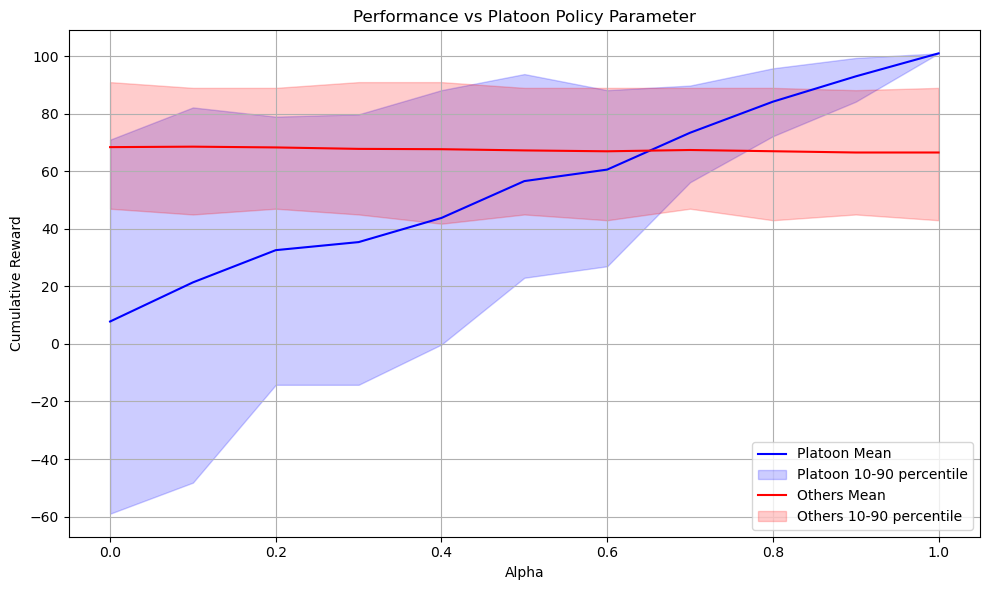


Numerical Results:
Alpha	Platoon Mean	10th	90th	Others Mean	10th	90th
----------------------------------------------------------------------
0.0	7.80	-59.00	71.00	68.41	47.00	91.00
0.1	21.40	-48.20	82.20	68.57	45.00	89.00
0.2	32.60	-14.20	79.00	68.30	47.00	89.00
0.3	35.40	-14.20	79.80	67.80	45.00	91.00
0.4	43.80	-0.20	88.20	67.69	41.80	91.00
0.5	56.60	23.00	93.80	67.27	45.00	89.00
0.6	60.60	27.00	88.20	66.96	43.00	89.00
0.7	73.40	56.20	89.80	67.41	47.00	89.00
0.8	84.20	72.20	95.80	66.98	43.00	89.00
0.9	93.00	84.20	99.40	66.54	45.00	88.20
1.0	101.00	101.00	101.00	66.54	43.00	89.00


In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, means_platoon, 'b-', label='Platoon Mean')
plt.fill_between(alpha_values, p10s_platoon, p90s_platoon, alpha=0.2, color='blue', label='Platoon 10-90 percentile')
plt.plot(alpha_values, means_others, 'r-', label='Others Mean')
plt.fill_between(alpha_values, p10s_others, p90s_others, alpha=0.2, color='red', label='Others 10-90 percentile')
plt.xlabel('Alpha')
plt.ylabel('Cumulative Reward')
plt.title('Performance vs Platoon Policy Parameter')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("Alpha\tPlatoon Mean\t10th\t90th\tOthers Mean\t10th\t90th")
print("-" * 70)
for rp, ro in zip(results_platoon, results_others):
    print(f"{rp['alpha']:.1f}\t{rp['mean']:.2f}\t{rp['p10']:.2f}\t{rp['p90']:.2f}\t{ro['mean']:.2f}\t{ro['p10']:.2f}\t{ro['p90']:.2f}")

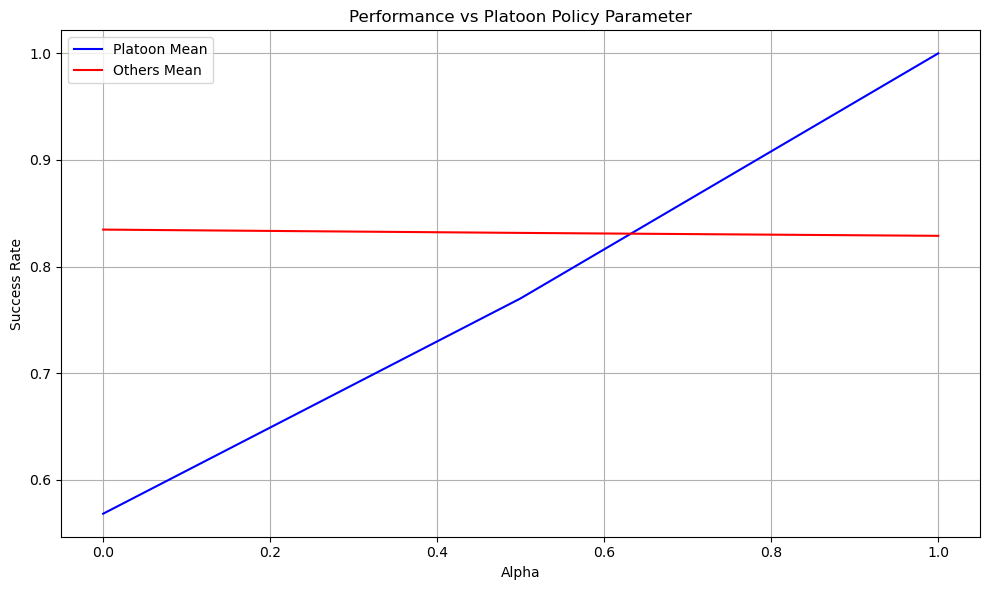

<Figure size 640x480 with 0 Axes>

In [20]:
# Create alpha values from 0 to 1 in 0.1 steps
alphas = np.linspace(0, 1, 11)
results_platoon = []
results_others = []



# Plot 2: Success Rate

plt.figure(figsize=(10, 6))
plt.plot(alpha_values, succmean_platoon, 'b-', label='Platoon Mean')
#plt.fill_between(alpha_values, succp10s_platoon, succp90s_platoon, alpha=0.2, color='blue', label='Platoon 10-90 percentile')
plt.plot(alpha_values, succmean_others, 'r-', label='Others Mean')
#plt.fill_between(alpha_values, succp10s_others, succp90s_others, alpha=0.2, color='red', label='Others 10-90 percentile')
plt.xlabel('Alpha')
plt.ylabel('Success Rate')
plt.title('Performance vs Platoon Policy Parameter')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [ ]:
print(succmean_platoon)
print(succmean_others)

[]
[]
